## Run the first 4 cells to import data and create training and testing set

In [3]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN,LSTM, Dense, Activation
from keras.utils import to_categorical
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from UtilNNDL import *

In [16]:
"""
#file_path = '/home/carla/Downloads/project_datasets/project_datasets/'
file_path = '/home/kunal/Desktop/FinalProject/datasets/A01T_slice.mat'

A01T = h5py.File(file_path,'r')
data = np.copy(A01T['image'])
data = np.transpose(data,(0,2,1))
data = data[:,:,:22]
labels = np.copy(A01T['type'])
labels = labels[0,0:data.shape[0]:1]
labels = np.asarray(labels, dtype=np.int32)

a = data[:56]
b = data[57:]
data = np.vstack((a,b))
a = labels[:56]
b = labels[57:]
labels = np.hstack((a,b))
#enc = OneHotEncoder()
#enc_labels = enc.fit_transform(labels.reshape(-1,1)).toarray()
enc_labels = to_categorical(labels-769, num_classes=4)
print(enc_labels)

#scaler = StandardScaler()
#data = scaler.fit_transform(data,enc_labels)
"""

[[ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 ..., 
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]]


In [17]:
"""
bs, t, f = data.shape
np.random.seed(42)
shuffle = np.random.choice(bs,bs,replace=False)

train_samples = 237
train_data = data[shuffle[:train_samples],:,:]
train_labels = enc_labels[shuffle[:train_samples]]
test_data = data[shuffle[train_samples:],:,:]
test_labels =enc_labels[shuffle[train_samples:]]

train_data = np.transpose(train_data,(0,2,1))
test_data = np.transpose(test_data,(0,2,1))

train_data,train_labels = create_window_data(train_data,train_labels)
test_data,test_labels = create_window_data(test_data,test_labels)

train_data = np.transpose(train_data,(0,2,1))
test_data = np.transpose(test_data,(0,2,1))

bs, t, f = train_data.shape
"""

In [30]:
#Prepare the data by taking out nans and dividing into test and train
#file_path = '/home/carla/Downloads/project_datasets/project_datasets/'
file_path = '/home/kunal/Desktop/FinalProject/datasets/'
train_data, test_data, train_labels, test_labels = prepare_data(file_path, 
                                                                num_test_samples = 50, 
                                                                verbose= False, 
                                                                return_all=True,
                                                                num_files =1)
print train_data.shape
print train_labels.shape
print test_data.shape
print test_labels.shape

(237, 22, 1000)
(237, 4)
(50, 22, 1000)
(50, 4)


In [31]:
#assist numerical stability
train_data = train_data*(1e6)
test_data = test_data*(1e6)

In [32]:
#Bandpass filter the data
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2)
print train_data.shape
print test_data.shape
for i,a in enumerate(train_data):
    train_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)
for i,a in enumerate(test_data):
    test_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)    
print train_data.shape
print test_data.shape

(237, 1000, 22)
(50, 1000, 22)
(237, 1000, 22)
(50, 1000, 22)


In [33]:
#Standardize the data
for i,a in enumerate(train_data):
    train_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
for i,a in enumerate(test_data):
    test_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2) 
print train_data.shape
print test_data.shape

(237, 22, 1000)
(50, 22, 1000)


In [40]:
#Augment the data into a bigger set by windowing
train_data_sliced, train_labels_sliced = create_window_data(train_data, train_labels, windows=10,window_size=512)
test_data_sliced, test_labels_sliced = create_window_data(test_data, test_labels, windows=10)

train_data_sliced = train_data_sliced.swapaxes(1,2)
test_data_sliced = test_data_sliced.swapaxes(1,2) 

bs,t,f = train_data_sliced.shape

print train_data_sliced.shape
print train_labels_sliced.shape
print test_data_sliced.shape
print test_labels_sliced.shape

(2370, 512, 22)
(2370, 4)
(500, 512, 22)
(500, 4)


# Everything from this point down is Testing

In [18]:
model = Sequential([
    LSTM(100, input_shape=(t,f)),
    Dense(32),
    Activation('relu'),
    #Dense(64),
    #Activation('relu'),
    Dense(32),
    Activation('relu'),
    Dense(4),
    Activation('softmax'),
])

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(train_data,train_labels,epochs=15,validation_split=0.25,batch_size=32,verbose=0)
test_score = model.evaluate(test_data, test_labels, batch_size=32)

print(test_score)

plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')

KeyboardInterrupt: 

## Modified VGGnet for this type of data

Modified VGG net to handle our input i.e. replace 2D with 1D, etc.(need to check dimensions and might need to transpose input to original shape)

Original VGGnet implementation can be found at hte address below

Train on 1777 samples, validate on 593 samples
Epoch 1/15
1777/1777 [==============================] - 12s 7ms/step - loss: 2.7620 - acc: 0.2577 - val_loss: 1.3851 - val_acc: 0.2951
Epoch 2/15
1777/1777 [==============================] - 10s 6ms/step - loss: 1.3756 - acc: 0.2769 - val_loss: 1.3691 - val_acc: 0.2901
Epoch 3/15
1777/1777 [==============================] - 10s 6ms/step - loss: 1.3377 - acc: 0.3219 - val_loss: 1.2527 - val_acc: 0.4503
Epoch 4/15
1777/1777 [==============================] - 11s 6ms/step - loss: 1.2020 - acc: 0.4232 - val_loss: 1.0793 - val_acc: 0.4857
Epoch 5/15
1777/1777 [==============================] - 11s 6ms/step - loss: 1.0794 - acc: 0.4620 - val_loss: 1.0039 - val_acc: 0.5160
Epoch 6/15
1777/1777 [==============================] - 12s 7ms/step - loss: 1.0172 - acc: 0.4772 - val_loss: 0.9707 - val_acc: 0.4992
Epoch 7/15
1777/1777 [==============================] - 13s 8ms/step - loss: 0.9315 - acc: 0.5093 - val_loss: 1.0655 - val_acc: 0.4418
Epoch 8/

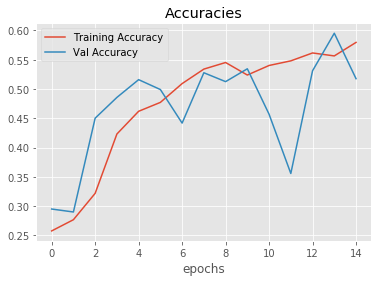

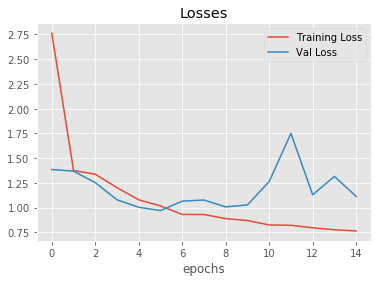

In [46]:
### VGGnet
# https://keras.io/getting-started/sequential-model-guide/#examples

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras.optimizers import SGD

norm_train = np.transpose((-np.mean(train_data,axis=2)+np.transpose(train_data,(2,0,1)))/np.std(train_data,axis=2),(1,2,0))
norm_test = np.transpose((-np.mean(test_data,axis=2)+np.transpose(test_data,(2,0,1)))/np.std(test_data,axis=2),(1,2,0))

model = Sequential()
#model.add(LSTM(100, input_shape=(t,f)))
model.add(Conv1D(32, 4, activation='relu',input_shape=(t,f)))             #Originally 32 each
model.add(BatchNormalization())
model.add(Conv1D(32, 4, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))

model.add(Conv1D(64, 4, activation='relu'))                                    #Originally 64 each
model.add(BatchNormalization())
model.add(Conv1D(64, 4, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(train_data_sliced,train_labels_sliced,epochs=15,validation_split=0.25,batch_size=32,verbose=1)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=32)

print(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')

Simple RNN model

500/500 [==============================] - 1s 1ms/step
[1.438882619857788, 0.25000000005960465]


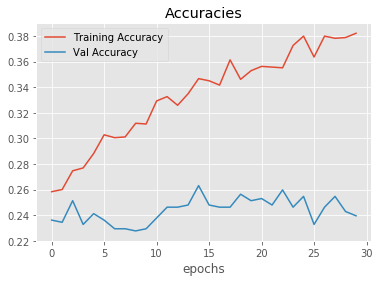

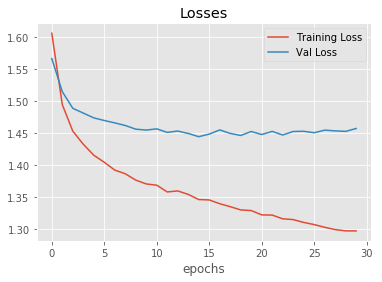

In [42]:
model = Sequential([
    SimpleRNN(64, input_shape=(t,f)),
    Dense(32),
    BatchNormalization(),
    Activation('relu'),
    Dense(4),
    Activation('softmax'),
])

model.compile(optimizer = 'sgd',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(train_data,train_labels,epochs=30,validation_split=0.25,batch_size=64,verbose=0)
test_score = model.evaluate(test_data, test_labels, batch_size=32)

print(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')

# CHRONONET PAPER

## C-RNN implementation (Figure 1b)

Train on 1777 samples, validate on 593 samples
Epoch 1/15
1777/1777 [==============================] - 16s 9ms/step - loss: 1.3795 - acc: 0.2988 - val_loss: 1.3649 - val_acc: 0.2546
Epoch 2/15
1777/1777 [==============================] - 15s 8ms/step - loss: 1.2895 - acc: 0.3832 - val_loss: 1.3480 - val_acc: 0.3221
Epoch 3/15
1777/1777 [==============================] - 16s 9ms/step - loss: 1.1189 - acc: 0.4778 - val_loss: 1.2941 - val_acc: 0.3322
Epoch 4/15
1777/1777 [==============================] - 15s 8ms/step - loss: 0.9349 - acc: 0.5582 - val_loss: 1.2390 - val_acc: 0.4165
Epoch 5/15
1777/1777 [==============================] - 16s 9ms/step - loss: 0.8677 - acc: 0.5869 - val_loss: 1.0405 - val_acc: 0.4924
Epoch 6/15
1777/1777 [==============================] - 15s 8ms/step - loss: 0.8094 - acc: 0.6314 - val_loss: 1.2984 - val_acc: 0.4418
Epoch 7/15
1777/1777 [==============================] - 14s 8ms/step - loss: 0.7327 - acc: 0.6517 - val_loss: 1.1225 - val_acc: 0.4975
Epoch 8/

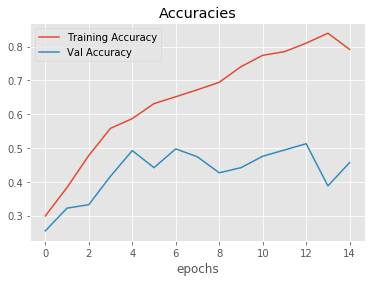

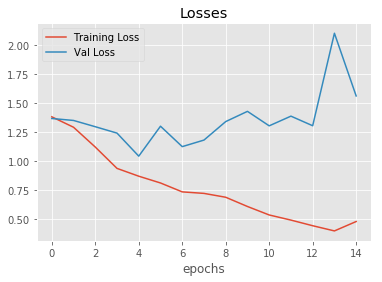

In [21]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization,GRU
from keras.optimizers import SGD


model = Sequential()

model.add(Conv1D(32, 4, strides=2,activation='relu',input_shape=(t,f)))
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(Conv1D(32, 4, strides=2,activation='relu'))

#model.add(Flatten())

model.add(GRU(32,activation='tanh',return_sequences=True))
model.add(GRU(32,activation='tanh',return_sequences=True))
model.add(GRU(32,activation='tanh',return_sequences=True))
model.add(GRU(32,activation='tanh'))


model.add(Dense(4, activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd)

#model.add()

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(norm_train,train_labels,epochs=15,validation_split=0.25,batch_size=32,verbose=1)
test_score = model.evaluate(norm_test, test_labels, batch_size=32)
print(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')

Implementation of Figure 1b but adding regularization structures like that found in VGGnet

500/500 [==============================] - 1s 1ms/step
[1.1770159482955933, 0.63999999904632565]


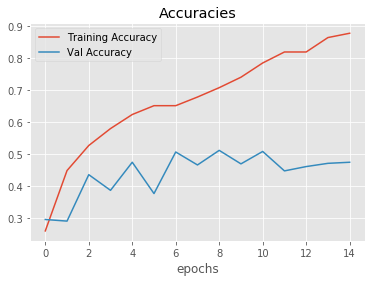

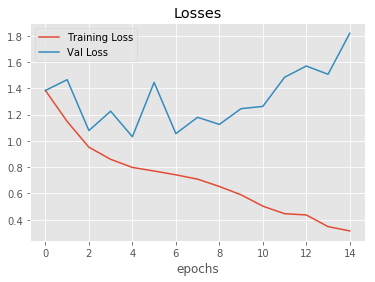

In [74]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization,GRU
from keras.optimizers import SGD

#norm_train = np.transpose((-np.mean(train_data,axis=2)+np.transpose(train_data,(2,0,1)))/np.std(train_data,axis=2),(1,2,0))
model = Sequential()

model.add(Conv1D(32, 4, strides=2,activation='relu',input_shape=(t,f)))
model.add(BatchNormalization())                            #From VGGnet
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(BatchNormalization())                            #From VGGnet
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(MaxPooling1D())                                  #From VGGnet
model.add(Dropout(0.25))                                   #From VGGnet
#model.add(Flatten())

model.add(GRU(32,activation='tanh',return_sequences=True))
model.add(GRU(32,activation='tanh',return_sequences=True))
model.add(GRU(32,activation='tanh',return_sequences=True))  #removed because of overfitting problem to small sample size
model.add(GRU(32,activation='tanh'))

#model.add(Dense(256, activation='relu'))                   #From VGGnet, but makes model suck
#model.add(Dropout(0.5))                                    #From VGGnet, but makes model suck
model.add(Dense(4, activation='softmax'))

# From VGGnet, works well for some reason
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data,train_labels,epochs=15,validation_split=0.25,batch_size=32,verbose=0)
test_score = model.evaluate(test_data, test_labels, batch_size=32)
print(test_score)

plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


Replaced GRU with LSTM

500/500 [==============================] - 1s 1ms/step
Test Results are  [0.99758425903320314, 0.63000000095367437]


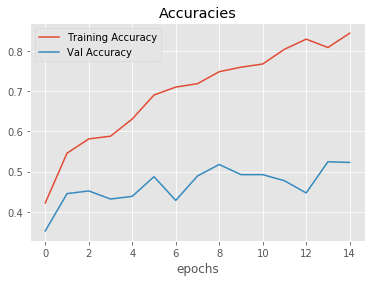

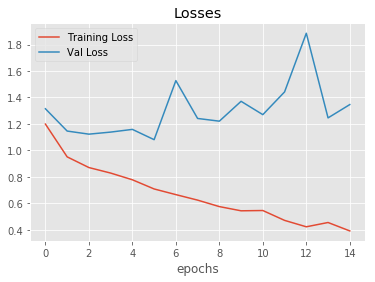

In [72]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization,GRU,LSTM
from keras.optimizers import SGD

#norm_train = np.transpose((-np.mean(train_data,axis=2)+np.transpose(train_data,(2,0,1)))/np.std(train_data,axis=2),(1,2,0))
model = Sequential()

model.add(Conv1D(32, 4, strides=2,activation='relu',input_shape=(t,f)))
model.add(BatchNormalization())                            #From VGGnet
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(BatchNormalization())                            #From VGGnet
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(MaxPooling1D())                                  #From VGGnet
model.add(Dropout(0.25))                                   #From VGGnet
#model.add(Flatten())

model.add(LSTM(32,activation='tanh',return_sequences=True))
model.add(LSTM(32,activation='tanh',return_sequences=True))
#model.add(LSTM(32,activation='tanh',return_sequences=True))
model.add(LSTM(32,activation='tanh'))

#model.add(Dense(256, activation='relu'))                   #From VGGnet, but makes model suck
#model.add(Dropout(0.5))                                    #From VGGnet, but makes model suck
model.add(Dense(4, activation='softmax'))

# From VGGnet, works well for some reason
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data,train_labels,epochs=15,validation_split=0.25,batch_size=32,verbose=0)
test_score = model.evaluate(test_data, test_labels, batch_size=32)

print "Test Results are ", test_score
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


## IC-RNN

500/500 [==============================] - 1s 3ms/step
Test Results are  [1.7054030046463013, 0.43000000286102297]


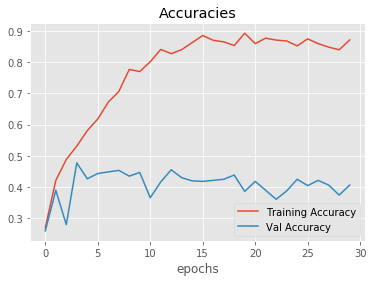

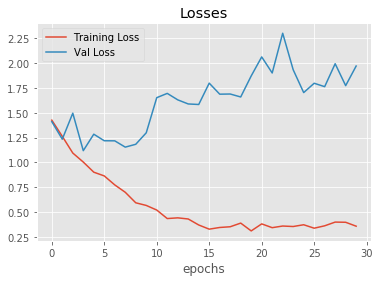

In [22]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from keras.models import Model

inputs= Input(shape=(t,f))

# First Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(inputs)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(inputs)
x = concatenate([tower1,tower2,tower3],axis=2)

# Second Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
x = concatenate([tower1,tower2,tower3],axis=2)

# Third Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
x = concatenate([tower1,tower2,tower3],axis=2)


x = GRU(32,activation='tanh',return_sequences=True)(x)
#x = GRU(32,activation='tanh',return_sequences=True)(x)
#x = GRU(32,activation='tanh',return_sequences=True)(x)
x = GRU(32,activation='tanh')(x)


predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(norm_train,train_labels,epochs=30,validation_split=0.25,batch_size=64,verbose=0)
test_score = model.evaluate(norm_test, test_labels, batch_size=64)

print "Test Results are ", test_score
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


### IC-RNN Testing

500/500 [==============================] - 1s 1ms/step
Test Results are  [1.0994007132053376, 0.4920000009536743]


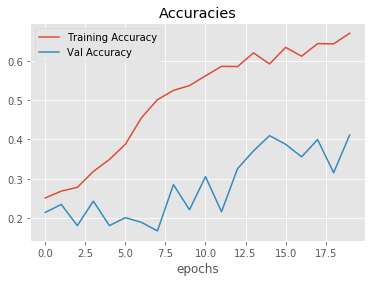

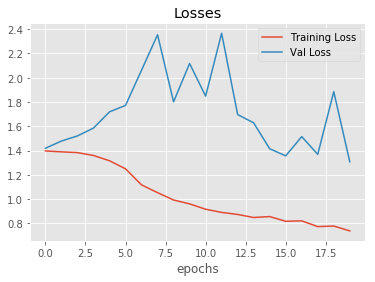

In [100]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D,Bidirectional
from keras.models import Model

inputs= Input(shape=(t,f))

# First Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(inputs)
#tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(inputs)
tower3 = BatchNormalization()(tower3)
#tower4 = MaxPooling1D()(inputs)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.5)(x)

# Second Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
#tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
tower3 = BatchNormalization()(tower3)
#tower4 = MaxPooling1D()(x)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.5)(x)


# Third Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
#tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
tower3 = BatchNormalization()(tower3)
#tower4 = MaxPooling1D()(x)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.5)(x)


x = (GRU(32,activation='tanh',return_sequences=True))(x)
x = (GRU(32,activation='tanh',return_sequences=True))(x)
#x = (GRU(32,activation='tanh',return_sequences=True))(x)
x = (GRU(32,activation='tanh'))(x)


predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data,train_labels,epochs=20,validation_split=0.25,batch_size=32,verbose=0)
test_score = model.evaluate(test_data, test_labels, batch_size=32)

print "Test Results are ", test_score
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


## C-DRNN

In [8]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from keras.models import Model

inputs= Input(shape=(t,f))

x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)

res1 = GRU(32,activation='tanh',return_sequences=True)(x)
res2 = GRU(32,activation='tanh',return_sequences=True)(res1)

res1_2 = concatenate([res1,res2],axis=2)

res3 = GRU(32,activation='tanh',return_sequences=True)(res1_2)

x = concatenate([res1,res2,res3])

x = GRU(32,activation='tanh')(x)
predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data,train_labels,epochs=15,validation_split=0.25,batch_size=32,verbose=0)
test_score = model.evaluate(test_data, test_labels, batch_size=32)

50/50 [==============================] - 0s 4ms/step


Test Results are  [1.8914880275726318, 0.30000000238418578]


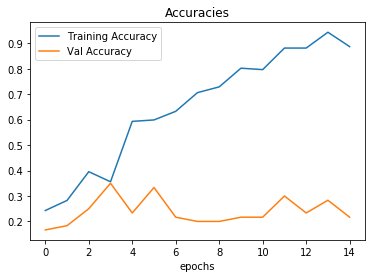

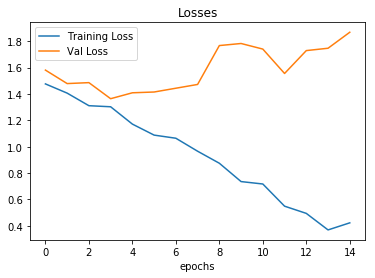

In [9]:
print "Test Results are ", test_score
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


### C-DRNN Testing

500/500 [==============================] - 2s 4ms/step
Test Results are  [1.1681010141372681, 0.43600000047683718]


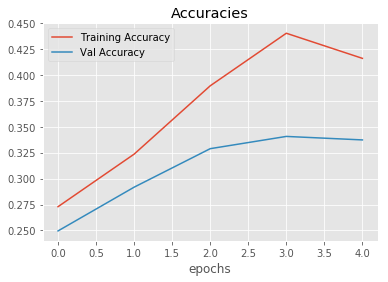

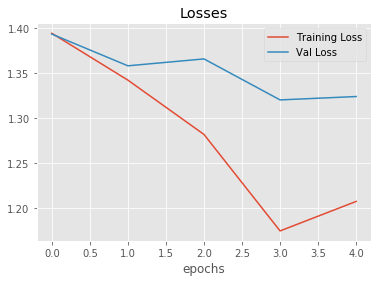

In [11]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D,BatchNormalization,Dropout
from keras.models import Model

inputs= Input(shape=(t,f))

x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
x = BatchNormalization()(x)
x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
x = BatchNormalization()(x)
#x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
x = Dropout(0.5)(x)

res1 = GRU(32,activation='tanh',return_sequences=True)(x)
res2 = GRU(32,activation='tanh',return_sequences=True)(res1)

res1_2 = concatenate([res1,res2],axis=2)

res3 = GRU(32,activation='tanh',return_sequences=True)(res2)

x = concatenate([res1,res2,res3])

x = GRU(32,activation='tanh')(x)
predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data,train_labels,epochs=5,validation_split=0.25,batch_size=32,verbose=0)
test_score = model.evaluate(test_data, test_labels, batch_size=32)

print "Test Results are ", test_score
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


## ChronoNet

In [49]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from keras.models import Model

inputs= Input(shape=(t,f))

# First Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(inputs)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(inputs)
x = concatenate([tower1,tower2,tower3],axis=2)

# Second Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
x = concatenate([tower1,tower2,tower3],axis=2)

# Third Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
x = concatenate([tower1,tower2,tower3],axis=2)

res1 = GRU(32,activation='tanh',return_sequences=True)(x)
res2 = GRU(32,activation='tanh',return_sequences=True)(res1)

res1_2 = concatenate([res1,res2],axis=2)

res3 = GRU(32,activation='tanh',return_sequences=True)(res2)

x = concatenate([res1,res2,res3])

x = GRU(32,activation='tanh')(x)
predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data,train_labels,epochs=30,validation_split=0.25,batch_size=32,verbose=0)
test_score = model.evaluate(test_data, test_labels, batch_size=32)

50/50 [==============================] - 0s 7ms/step


Testing Accuracy is [1.6881582021713257, 0.2600000047683716]


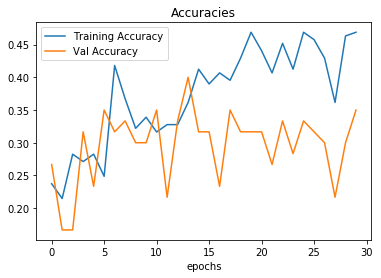

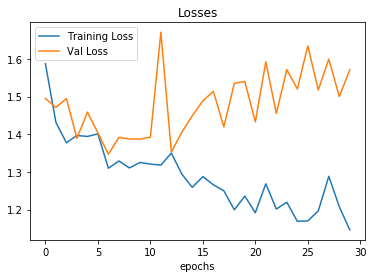

In [50]:
print "Testing Accuracy is", test_score
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


### ChronoNet Model Testing

500/500 [==============================] - 2s 5ms/step
Testing Accuracy is [1.3958248071670531, 0.47799999785423281]


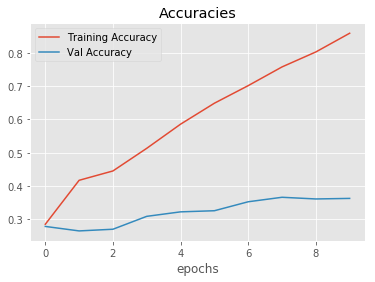

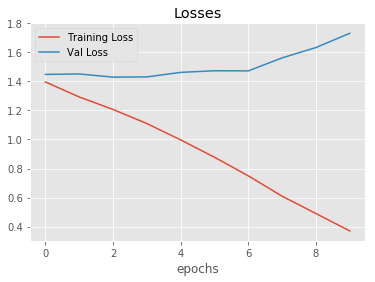

In [13]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from keras.models import Model

inputs= Input(shape=(t,f))

# First Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(inputs)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(inputs)
tower3 = BatchNormalization()(tower3)
x = concatenate([tower1,tower2,tower3],axis=2)

# Second Inception
#tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
#tower1 = BatchNormalization()(tower1)
#tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
#tower2 = BatchNormalization()(tower2)
#tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
#tower3 = BatchNormalization()(tower3)
#x = concatenate([tower1,tower2,tower3],axis=2)

# Third Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
tower3 = BatchNormalization()(tower3)
x = concatenate([tower1,tower2,tower3],axis=2)

res1 = GRU(32,activation='tanh',return_sequences=True)(x)
res2 = GRU(32,activation='tanh',return_sequences=True)(res1)

res1_2 = concatenate([res1,res2],axis=2)

res3 = GRU(32,activation='tanh',return_sequences=True)(res2)

x = concatenate([res1,res2,res3])

x = GRU(32,activation='tanh')(x)
predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data,train_labels,epochs=10,validation_split=0.25,batch_size=128,verbose=0)
test_score = model.evaluate(test_data, test_labels, batch_size=128)

print "Testing Accuracy is", test_score
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')
